# Stochastic volatility
This Notebook demos how to construct a stochastic volatility model and fit it to data. We will use the precision model of G. Chacko and L. M. Viceira. `Dynamic consumption and portfolio choice with stochastic volatility in incomplete markets` given by
\begin{cases}
\mathrm{d}Y_t = \left (\mu + \beta e^{-V_t} \right ) \mathrm{d}t + e^{-V_t/2} \mathrm{d}W_t, \\
\mathrm{d}V_t = \kappa \left (\gamma - V_t \right ) \mathrm{d}t + \sigma \mathrm{d}B_t, \\
\end{cases}
where $\mu, \beta, \gamma \in \mathbb{R}$, and $\kappa, \sigma \in \mathbb{R}_+$. $\{W_t\}$ and $\{V_t\}$ are two one-dimensional, assumed independent, Wiener processes. As the above model is defined in continuous time, we need to discretize it; we do so using the Euler-Maruyma scheme.

We begin with importing the necessary libraries for defining the model.

In [1]:
from pyfilter.timeseries import StateSpaceModel, EulerMaruyma, Observable

Next, we define the governing dynamics. We assume that the initial distribution of the model is given by 
\begin{equation}
V_0 \sim \mathcal{N} \left ( \gamma, \frac{\sigma}{\sqrt{2 \kappa}} \right ),
\end{equation}
so that we get the following functions

In [2]:
import numpy as np

def fh0(reversion, level, std):
    return level


def gh0(reversion, level, std):
    return std / np.sqrt(2 * reversion)


def fh(x, reversion, level, std):
    return reversion * (level - x)


def gh(x, reversion, level, std):
    return std


def go(vol, level, beta):
    return level + beta * np.exp(-vol) / 2


def fo(vol, level, beta):
    return np.exp(-vol / 2)

Next, we shall define our model. In order to do so, we must specify priors for the different parameters. Given their support, we assume that
\begin{cases}
    \mu, \gamma \sim \mathcal{N}(0, 1), \\
    \kappa, \sigma \sim \Gamma(4, 0.1), \\
\end{cases}
and for simplicity that $\beta \triangleq 0$. To do this, we need to import the necessary distributions.

In [3]:
from pyfilter.distributions.continuous import Gamma, Normal

Next, we define the model in terms of code and get

In [4]:
volparams = Gamma(4, scale=0.1), Normal(), Gamma(4, scale=0.1)
logvol = EulerMaruyma((fh0, gh0), (fh, gh), volparams, (Normal(), Normal()))
obs = Observable((go, fo), (Normal(), 0), Normal())

stockmodel = StateSpaceModel(logvol, obs)

And that defines the model. Next, we need a dataset to train on. We're just going to pick one of the stocks represented in the S&P500, and that is Conoco Phillips (`COP`). We load the data using Quandl and get, starting from 2010 and onwards

In [5]:
import quandl
import numpy as np

stock = 'COP'
y = np.log(quandl.get('WIKI/{:s}'.format(stock), start_date='2010-01-01', column_index=11, transform='rdiff') + 1)
y *= 100

We plot the data to get an idea of its volatility

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18, 16))

y.plot(ax=ax)
plt.show()

From the above plot we clearly see that Conoco Phillips is volatile for the majority of the period, but clear a volatility cluster at the beginning of 2016. In order to fit the model to the given data, we need an algorithm. We shall use a combination of NESS and SMC$^2$. We use SMC$^2$ for the first part of the data set, and then switch to NESS. Furthermore, since we are using particle filters, we need to decide on which proposal to use - should we go with the Bootstrap or something more advanced? For this example, we will use a linearized version. Importing the relevant classes, we get

In [7]:
from pyfilter.filters import NESSMC2, NESS, APF, KalmanLaplace

Let us now fit the model to the data, and time the process!

In [8]:
import time
predictions = 10
start = time.time()
alg = NESS(stockmodel.copy(), (1000,), filt=KalmanLaplace).initialize().longfilter(y.iloc[:-predictions])
alg2 = NESS(stockmodel.copy(), (1000,), filt=KalmanLaplace).initialize().longfilter(y.iloc[:-predictions])
print('Took {:.0f} seconds to finish the filtering procedure for {:d} observations'.format(time.time() - start, y.size))

C:\Users\victo\Desktop\pyfilter\pyfilter\utils\utils.py:352: RuntimeWarning: invalid value encountered in true_divide
  p = p / np.sqrt((p ** 2).sum(axis=0))


Took 272 seconds to finish the filtering procedure for 2070 observations


We plot the filtered volatility component and superimpose it on the returns to see if it correctly captures the observed behavior

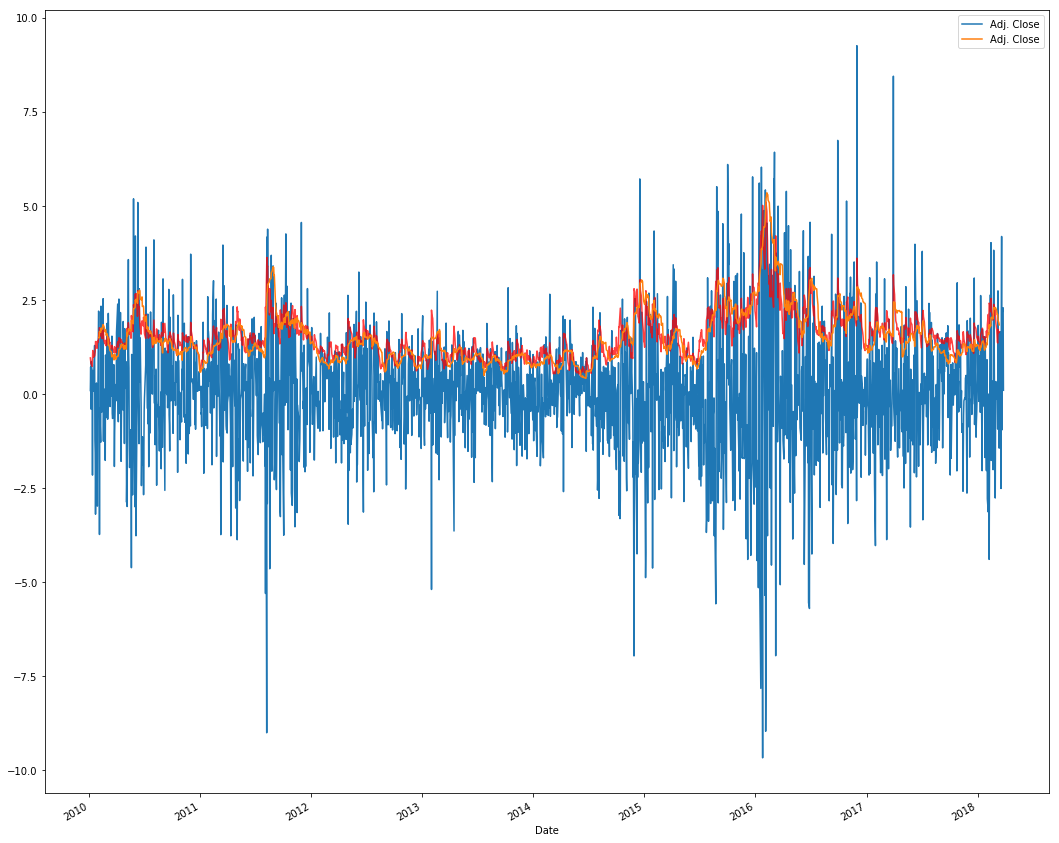

In [9]:
fig, ax = plt.subplots(figsize=(18, 16))
y.plot(ax=ax)
ax.plot(y.index[:-predictions], np.exp(-np.array(alg.filtermeans()) / 2), 'r', alpha=0.75)

y.iloc[:-predictions].rolling(20).std().plot(ax=ax)

plt.show()

We also plot the distribution of the residuals together with a normal distribution to see if it's a good fit

TypeError: Empty 'DataFrame': no numeric data to plot

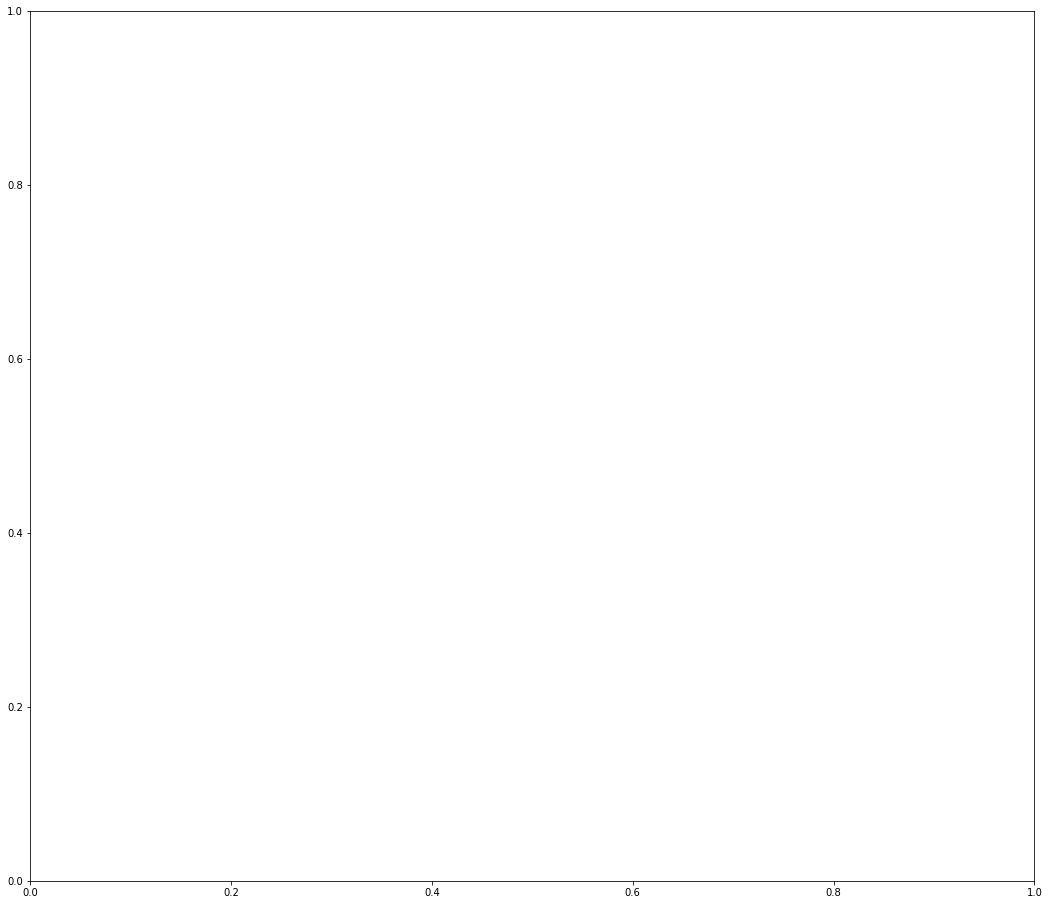

In [10]:
import pandas as pd
from scipy.stats import norm

fig, ax = plt.subplots(figsize=(18, 16))
nm = pd.Series(alg.noisemeans())
nm.plot.kde(ax=ax, label='Residuals')

x = np.linspace(nm.min() - 4, nm.max() + 4, 500)
ax.plot(x, norm.pdf(x), 'r', label='$\mathcal{N}(0, 1)$')
plt.legend()
plt.show()

A visual inspection suggests that this is indeed a good fit.

In [ ]:
fig, ax = plt.subplots(figsize=(18, 16))

ax.acorr(alg.noisemeans(), maxlags=50)

plt.show()

Let's also plot the posterior distributions

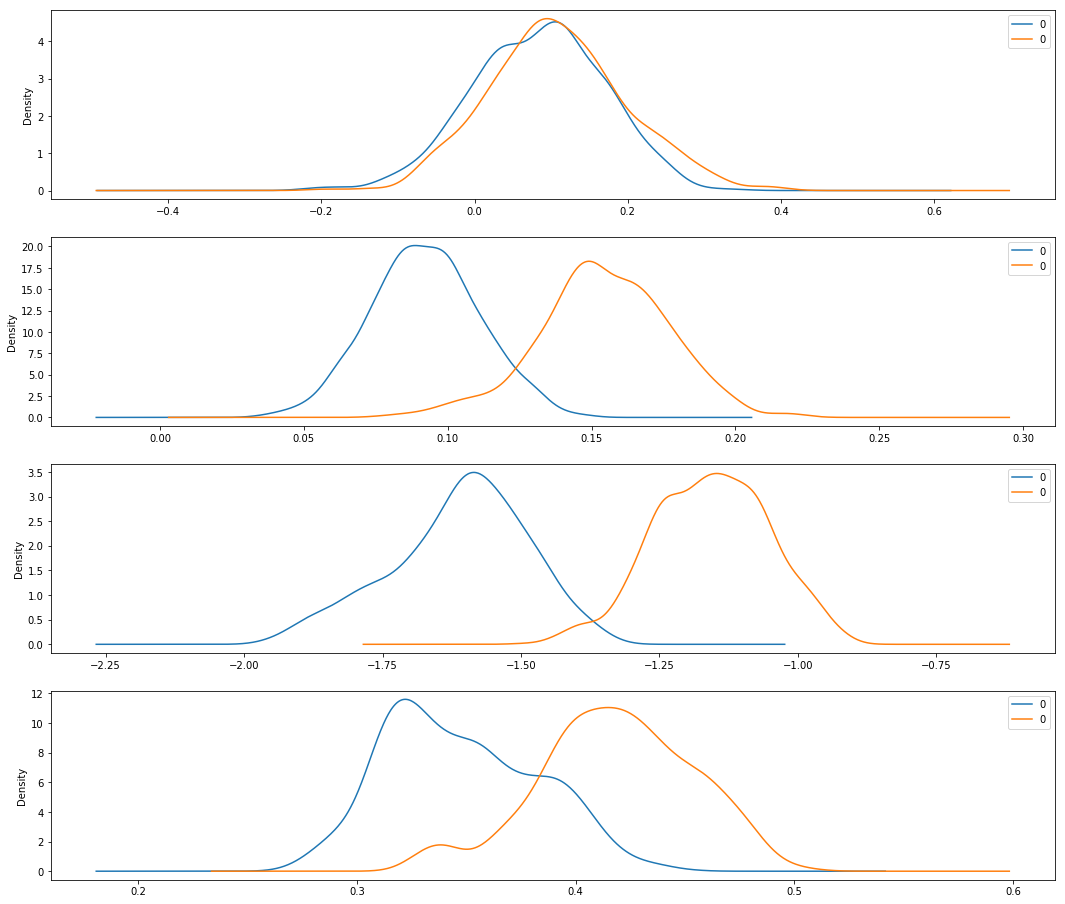

In [11]:
fig, ax = plt.subplots(4, figsize=(18, 16))

for a in [alg, alg2]:
    pd.DataFrame(a.ssm.observable.theta[0]).plot.kde(ax=ax[0])

    for i, p in enumerate(a.ssm.hidden.theta):
        pd.DataFrame(p).plot.kde(ax=ax[i+1])

plt.show()

Let's try and predict the future distributions of returns and superimpose the actual returns

In [ ]:
px, py = alg.predict(predictions)

cum_py = np.percentile(np.cumsum(py, axis=0), [1, 50, 99], axis=1).T

fig, ax = plt.subplots(figsize=(18, 16))

actualreturns = y.iloc[-predictions:].cumsum().values

ax.plot(y.index[-predictions:], actualreturns, label='Actual returns')
ax.plot(y.index[-predictions:], cum_py, 'r', alpha=0.5)

plt.legend()
plt.show()